In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Mounted at /content/drive
/content/drive/My Drive/ann challenge


In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()
import wandb

## Auxiliary functions

In [ ]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [ ]:
def plot_history(history, log_scale: bool = False) -> None:
  mae = history['mae']
  val_mae = history['val_mae']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmin(val_loss)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')

  if log_scale:
      plt.semilogy(loss, label='Training MSE', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation MSE', color='#4D61E2')
  else:
      plt.plot(loss, label='Training MSE', color='#ff7f0e')
      plt.plot(val_loss, label='Validation MSE', color='#4D61E2')

  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')

  if log_scale:
     plt.semilogy(mae, label='Training MAE', color='#ff7f0e')
     plt.semilogy(val_mae, label='Validation MAE', color='#4D61E2')
  else:
    plt.plot(mae, label='Training MAE', color='#ff7f0e')
    plt.plot(val_mae, label='Validation MAE', color='#4D61E2')

  plt.plot(best_epoch, history['val_mae'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build the model

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = y_train.shape[1:]        # Output shape for the model
batch_size = 256                        # Batch size for training
epochs = 200                            # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 256
Input Shape: (200, 1)
Output Shape: (9, 1)


In [ ]:
from tcn import TCN

In [ ]:
def TemporalConvNet(num_filters, kernel_size, return_sequences, dilations, dropout_rate=0.0, nb_stacks=1):
    return TCN(
        nb_filters=num_filters,
        kernel_size=kernel_size,
        dilations=dilations,
        nb_stacks=nb_stacks,
        use_skip_connections=True,
        dropout_rate=dropout_rate,
        return_sequences=return_sequences,
        activation='swish',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        use_batch_norm=False,
        go_backwards=False,
        return_state=False
    )

In [ ]:
# Helper function to compute the receptive field of a TCN
receptive_field = lambda k_size, dilations: 1 + 2 * (k_size - 1) * np.sum(dilations)

In [ ]:
print(receptive_field(2, (1, 2, 4, 8, 16, 32, 64)))
print(receptive_field(3, (1, 2, 4, 8, 16, 32)))
print(receptive_field(5, (1, 2, 4, 8, 16)))
print(receptive_field(7, (1, 2, 4, 8)))
print(receptive_field(9, (1, 2, 4, 8)))

255
253
249
181
241


In [ ]:
def build_model(input_shape, output_shape, hyperparams):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define hyperparameters
    initializer = tf.keras.initializers.HeNormal()
    num_filters =  hyperparams['num_filters']
    kernel_size = hyperparams['kernel_size']
    conv_dropout = hyperparams['conv_dropout']
    dense_dropout = hyperparams['dense_dropout']

    match kernel_size:
      case 5:
        dilations = (1, 2, 4, 8, 16)
      case 7:
        dilations = (1, 2, 4, 8)
      case 9:
        dilations = (1, 2, 4, 8)
      case _:
          raise ValueError("Unknown dilation size")

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Feature extractor
    x = TemporalConvNet(num_filters, kernel_size, return_sequences=True, dilations=dilations, dropout_rate=conv_dropout)(input_layer)
    x = tfkl.Flatten()(x)

    # Dense regressor
    while x.shape[1] > 512:
        x = tfkl.Dense(x.shape[1] // 4, kernel_initializer=initializer)(x)
        x = tfkl.Activation('swish')(x)
        x = tfkl.Dropout(dense_dropout)(x)

    output_layer = tfkl.Dense(9, activation='linear')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Temporal_CNN')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=(num_batches * 5), decay_rate=0.9, staircase=True)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_scheduler), metrics=['mae'])

    return model

In [ ]:
model = build_model(input_shape, output_shape, {'num_filters': 16, 'kernel_size': 9, 'conv_dropout': 0.3, 'dense_dropout': 0.2})
model_name = model.name
model.summary()

Model: "Temporal_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 tcn (TCN)                   (None, 200, 16)           16432     
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 800)               2560800   
                                                                 
 activation (Activation)     (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 200)              

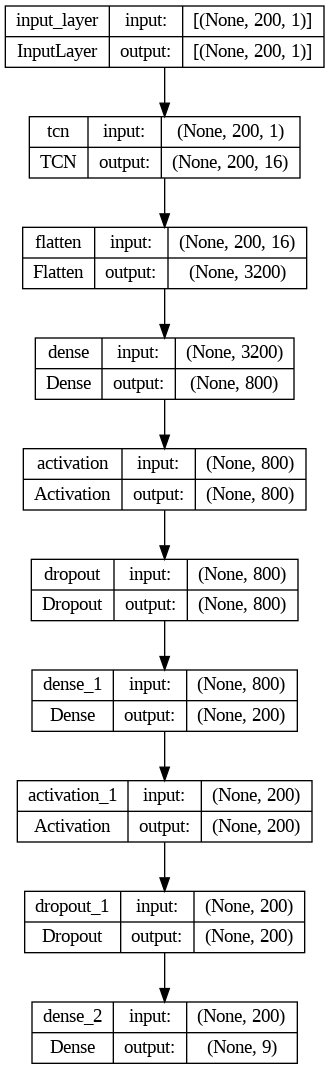

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
del model

In [ ]:
lr_patience = 5
es_patience = 15
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

## Tuning

In [ ]:
def run(config=None):
    with wandb.init(config=config):
        # Fix randomness
        seed = 42
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)
        tf.compat.v1.set_random_seed(seed)

        # Build the model
        config = wandb.config
        model = build_model(input_shape, output_shape, hyperparams=config)

        # Define callbacks
        callbacks = [
            tfk.callbacks.TerminateOnNaN(),
            tfk.callbacks.ReduceLROnPlateau('val_loss', patience=lr_patience, factor=0.3, min_lr=1e-5, verbose=1),
            tfk.callbacks.EarlyStopping('val_loss', patience=es_patience, min_delta=1e-4, restore_best_weights=True, verbose=1),
            wandb.keras.WandbMetricsLogger(log_freq='epoch'),
            # tfk.callbacks.ModelCheckpoint('checkpoints/' + model_name + '_{epoch:02d}', monitor='val_loss', save_freq=(num_batches * 3))
        ]

        # Train the model
        model.fit(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
        )
        del model

In [ ]:
# Start the hyperparameter sweep
wandb.agent('mbbt7ltu', run, count=None, project='anndl-forecasting')

wandb: Agent Starting Run: mgmde8dr with config:
wandb: 	conv_dropout: 0.15
wandb: 	dense_dropout: 0.25
wandb: 	kernel_size: 9
wandb: 	num_filters: 16
wandb: Currently logged in as: alberto-pirillo. Use `wandb login --relogin` to force relogin


Epoch 1/200
603/603 [==============================] - 24s 24ms/step - loss: 0.0303 - mae: 0.1180 - val_loss: 0.0102 - val_mae: 0.0691 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0137 - mae: 0.0838 - val_loss: 0.0111 - val_mae: 0.0723 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 13s 22ms/step - loss: 0.0123 - mae: 0.0783 - val_loss: 0.0095 - val_mae: 0.0635 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0114 - mae: 0.0746 - val_loss: 0.0098 - val_mae: 0.0679 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0110 - mae: 0.0727 - val_loss: 0.0091 - val_mae: 0.0622 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0104 - mae: 0.0702 - val_loss: 0.0093 - val_mae: 0.0660 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0101 - mae: 0.0692 - val_loss

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███▇▇▇▇▇▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▁▃▃▂▁▂▂▂▂▁
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▆▅▅▅▄▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▆▆▅▅▅▅▄▄▄▄▃▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁
epoch/epoch,78
epoch/learning_rate,6e-05
epoch/loss,0.00406
epoch/lr,0.00021


wandb: Agent Starting Run: t9qn7kqb with config:
wandb: 	conv_dropout: 0.05
wandb: 	dense_dropout: 0.25
wandb: 	kernel_size: 9
wandb: 	num_filters: 8


Epoch 1/200
603/603 [==============================] - 15s 15ms/step - loss: 0.0709 - mae: 0.1406 - val_loss: 0.0123 - val_mae: 0.0782 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0160 - mae: 0.0912 - val_loss: 0.0104 - val_mae: 0.0691 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 8s 12ms/step - loss: 0.0134 - mae: 0.0819 - val_loss: 0.0098 - val_mae: 0.0661 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0122 - mae: 0.0771 - val_loss: 0.0096 - val_mae: 0.0640 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 8s 13ms/step - loss: 0.0116 - mae: 0.0745 - val_loss: 0.0098 - val_mae: 0.0670 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0111 - mae: 0.0723 - val_loss: 0.0095 - val_mae: 0.0647 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 8s 13ms/step - loss: 0.0108 - mae: 0.0711 - val_loss: 0.00

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███▇▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▁▃▃▃▃▃▃▁▂▁▂▂▂▁▂▁▂▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,92
epoch/learning_rate,5e-05
epoch/loss,0.00534
epoch/lr,0.00015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pkiu76ef with config:
wandb: 	conv_dropout: 0.15
wandb: 	dense_dropout: 0.15
wandb: 	kernel_size: 9
wandb: 	num_filters: 8


Epoch 1/200
603/603 [==============================] - 12s 13ms/step - loss: 0.1028 - mae: 0.1601 - val_loss: 0.0162 - val_mae: 0.0953 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 7s 12ms/step - loss: 0.0204 - mae: 0.1050 - val_loss: 0.0113 - val_mae: 0.0747 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 7s 12ms/step - loss: 0.0155 - mae: 0.0898 - val_loss: 0.0104 - val_mae: 0.0711 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 7s 12ms/step - loss: 0.0133 - mae: 0.0820 - val_loss: 0.0100 - val_mae: 0.0669 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0122 - mae: 0.0773 - val_loss: 0.0096 - val_mae: 0.0657 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 8s 13ms/step - loss: 0.0115 - mae: 0.0744 - val_loss: 0.0097 - val_mae: 0.0660 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 7s 11ms/step - loss: 0.0111 - mae: 0.0726 - val_loss: 0.00

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███▇▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▂▄▄▃▁▃▃▁▃▃▃▁▂▁▂▂▁▂▁▂▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,92
epoch/learning_rate,5e-05
epoch/loss,0.00555
epoch/lr,0.00015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dve39dlc with config:
wandb: 	conv_dropout: 0.05
wandb: 	dense_dropout: 0.45
wandb: 	kernel_size: 9
wandb: 	num_filters: 16


Epoch 1/200
603/603 [==============================] - 18s 21ms/step - loss: 0.0290 - mae: 0.1174 - val_loss: 0.0101 - val_mae: 0.0687 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0141 - mae: 0.0855 - val_loss: 0.0105 - val_mae: 0.0693 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 13s 22ms/step - loss: 0.0126 - mae: 0.0796 - val_loss: 0.0098 - val_mae: 0.0653 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0118 - mae: 0.0761 - val_loss: 0.0096 - val_mae: 0.0657 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0114 - mae: 0.0743 - val_loss: 0.0095 - val_mae: 0.0652 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0109 - mae: 0.0721 - val_loss: 0.0096 - val_mae: 0.0664 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0107 - mae: 0.0712 - val_loss

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,███▇▇▇▇▆▆▅▅▅▅▅▅▅▄▄▂▄▃▃▃▁▃▃▁▃▃▃▃▂▁▂▂▁▂▁▂▂
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▇▆▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▇▇▆▆▅▅▅▄▄▄▃▅▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,90
epoch/learning_rate,5e-05
epoch/loss,0.00505
epoch/lr,0.00015


wandb: Agent Starting Run: ole0ayhs with config:
wandb: 	conv_dropout: 0.35
wandb: 	dense_dropout: 0.3
wandb: 	kernel_size: 9
wandb: 	num_filters: 16


Epoch 1/200
603/603 [==============================] - 17s 21ms/step - loss: 0.0420 - mae: 0.1360 - val_loss: 0.0109 - val_mae: 0.0732 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0157 - mae: 0.0912 - val_loss: 0.0103 - val_mae: 0.0680 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 12s 21ms/step - loss: 0.0134 - mae: 0.0828 - val_loss: 0.0096 - val_mae: 0.0639 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0124 - mae: 0.0787 - val_loss: 0.0094 - val_mae: 0.0635 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 12s 21ms/step - loss: 0.0117 - mae: 0.0759 - val_loss: 0.0094 - val_mae: 0.0642 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0111 - mae: 0.0735 - val_loss: 0.0092 - val_mae: 0.0632 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0108 - mae: 0.0720 - val_loss

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███▇▇▇▇▇▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▁▂▂▂▂▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▅▅▄▅▄▄▄▃▄▄▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁
epoch/epoch,78
epoch/learning_rate,6e-05
epoch/loss,0.00557
epoch/lr,0.00021


wandb: Agent Starting Run: 2fop4sw7 with config:
wandb: 	conv_dropout: 0.2
wandb: 	dense_dropout: 0.45
wandb: 	kernel_size: 9
wandb: 	num_filters: 16


Epoch 1/200
603/603 [==============================] - 21s 23ms/step - loss: 0.0346 - mae: 0.1279 - val_loss: 0.0105 - val_mae: 0.0710 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 13s 22ms/step - loss: 0.0150 - mae: 0.0890 - val_loss: 0.0105 - val_mae: 0.0688 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 13s 22ms/step - loss: 0.0132 - mae: 0.0820 - val_loss: 0.0098 - val_mae: 0.0656 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0122 - mae: 0.0779 - val_loss: 0.0097 - val_mae: 0.0665 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0117 - mae: 0.0756 - val_loss: 0.0099 - val_mae: 0.0678 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 12s 21ms/step - loss: 0.0112 - mae: 0.0733 - val_loss: 0.0093 - val_mae: 0.0636 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 12s 21ms/step - loss: 0.0109 - mae: 0.0723 - val_loss

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▆▆▅▅▄▄▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▆▆▆▅▅▄▄▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,105
epoch/learning_rate,3e-05
epoch/loss,0.00581
epoch/lr,0.00011


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Test a model

In [ ]:
model = tfk.models.load_model('models/' + model_name )

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")